In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Pre-Task: Describe the goals of your study

## Part 1: Aquire the Data

In [10]:
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents

#### 1. Connect to the remote database

In [21]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import connection

In [22]:
engine = create_engine(connection.params)
pd.read_sql("SELECT * FROM pg_catalog.pg_tables WHERE schemaname='public'", con=engine)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,public,train,dsi,None,True,False,False
1,public,table1,dsi_student,None,True,False,False


In [24]:
sql = """
SELECT * FROM train
"""

pd.read_sql(sql, con=engine)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
9,9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C


#### 2. Query the database and aggregate the data

In [141]:
# How many people in each Pclass

sql = """
SELECT "Pclass", Count("Pclass") FROM train
GROUP BY "Pclass"
"""

pclass_cnt = pd.read_sql(sql, con=engine)
pclass_cnt

,Pclass,count
0,1,216
1,2,184
2,3,491


In [158]:
# How many male and females

sql = """
SELECT "Sex", Count("Sex") FROM train
GROUP BY "Sex"
"""

sex_cnt = pd.read_sql(sql, con=engine)
sex_cnt

,Sex,count
0,male,577
1,female,314


In [159]:
# How many people embarked from each port

sql = """
SELECT "Embarked", COUNT("Embarked") FROM train
GROUP BY "Embarked"
"""

port_cnt = pd.read_sql(sql, con=engine)
port_cnt

,Embarked,count
0,Q,77
1,None,0
2,S,644
3,C,168


In [162]:
# Survival rate of males and females

sql = """
SELECT "Sex", "Survived", COUNT("Survived") AS Cnt_Surv
FROM train
GROUP BY "Sex", "Survived"
ORDER BY "Sex"
"""

surv_rate = pd.read_sql(sql, con=engine)
surv_rate

,Sex,Survived,cnt_surv
0,female,1,233
1,female,0,81
2,male,0,468
3,male,1,109


In [200]:
# sql = """
# SELECT "Sex", SUM(COUNT("Age" <= 17))
# FROM train
# WHERE "Age" <= 17
# GROUP BY "Sex", "Age"
# """

# pd.read_sql(sql, con=engine)

In [201]:
# sql = """
# SELECT "Age", COUNT("Sex") AS ct_sex, "Sex"
# From train
# GROUP BY "Sex", "Age"
# ORDER BY "Age" DESC
# """
# pd.read_sql(sql, con=engine)
## Result is 124 missing Age

In [186]:
# change table into dataframe

sql = """
SELECT * FROM train
"""

df = pd.read_sql(sql, con=engine)

#### 5. What are the risks and assumptions of our data? 

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [28]:
def describe_table(table="orders", connection=engine):
    
    sql = """
    SELECT
        column_name, data_type
    FROM
        information_schema.COLUMNS
    WHERE
        TABLE_NAME = '%s'
    """ % table

    return pd.read_sql(sql, con=connection)

In [29]:
describe_table("train", connection=engine)

,column_name,data_type
0,index,bigint
1,PassengerId,bigint
2,Survived,bigint
3,Pclass,bigint
4,Name,text
5,Sex,text
6,Age,double precision
7,SibSp,bigint
8,Parch,bigint
9,Ticket,text


In [51]:
df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [ ]:
# Copy the data to keep in original form
data = df.copy()

In [198]:
# data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'male' else 0)
# change NaN to 0

data.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


#### 2. Visualize the Data

In [59]:
import seaborn as sns

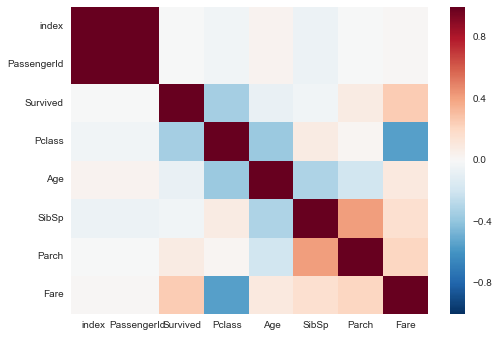

In [62]:
sns.heatmap(df.corr())

   Pclass  count
0       1    216
1       2    184
2       3    491


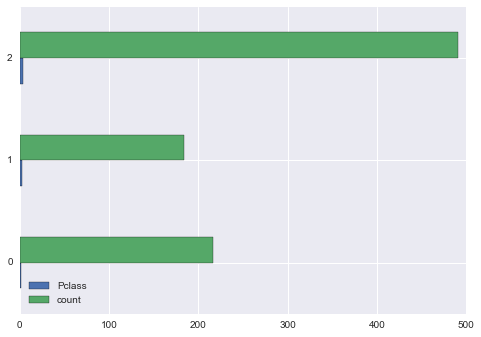

In [167]:
print pclass_cnt
pd.DataFrame(pclass_cnt).plot(kind='barh')

      Sex  count
0    male    577
1  female    314


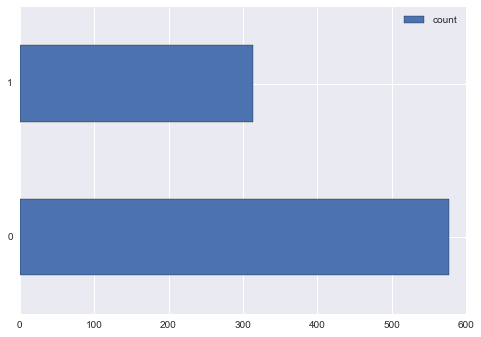

In [166]:
print sex_cnt
pd.DataFrame(sex_cnt).plot(kind='barh')

  Embarked  count
0        Q     77
1     None      0
2        S    644
3        C    168


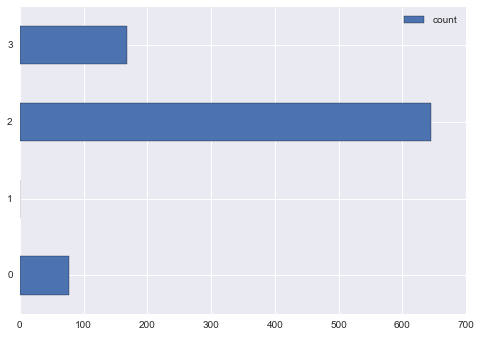

In [165]:
print port_cnt
pd.DataFrame(port_cnt).plot(kind='barh')

      Sex  Survived  cnt_surv
0  female         1       233
1  female         0        81
2    male         0       468
3    male         1       109


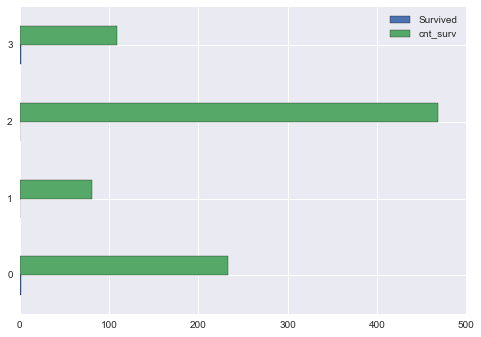

In [168]:
print surv_rate
pd.DataFrame(surv_rate).plot(kind='barh')

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [199]:
# change male =  1, female = 2
data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'male' else 0)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [ ]:
X = 

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

#### 3. Conduct the logistic regression

#### 4. Examine the coefficients to see our correlations

#### 6. Test the Model by introducing a *Test* or *Validaton* set 

#### 7. Predict the class labels for the *Test* set

#### 8. Predict the class probabilities for the *Test* set

#### 9. Evaluate the *Test* set

#### 10. Cross validate the test set

#### 11. Check the Classification Report

#### 12. What do the classification metrics tell us?

#### 13. Check the Confusion Matrix

#### 14. What does the Confusion Matrix tell us? 

#### 15. Plot the ROC curve

#### 16. What does the ROC curve tell us?

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [ ]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.